In [308]:
# Clear all variables in the workspace
%reset -f

## Imports

In [309]:
import custom_system_properties as csp

In [310]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy as sp

In [311]:
import discretisedfield as df
import micromagneticmodel as mm
import micromagneticdata as md

In [312]:
import oommfc as oc

## Main parameters

In [313]:
system = mm.System(name='dmi_sp')

system_prop = csp.SystemProperties(length=2000e-9, width=8e-9, thickness=1e-9)
system_prop.cell = (2e-9, 2e-9, 1e-9)
system_prop.units = ('m', 'm', 'm')
#system_prop.update_lengths()
system_prop.update_numcells()

In [314]:
system_prop

SystemProperties(length=2e-06, width=2e-07, thickness=1e-09, cell=(2e-09, 2e-09, 1e-09), p1=(0, 0, 0), units=('m', 'm', 'm'), p2=(2e-06, 2e-07, 1e-09), numcells=(1000, 100, 1))

In [315]:
# Saturisation magnetisation
sat_mag = 8.6e5  # kA/m

# exchange stiffness
exchange_stiffness = 1.3e-11  # J/m

# External static Zeeman field strength
bias_field = tuple(x/mm.consts.mu0 for x in [0, 0.4, 0])  # A/m

# External dynamic Zeeman field strength
h0 = tuple(x/mm.consts.mu0 for x in [0.04, 0, 0])  # A/m

# Driving frequency
f = 60e9  # Hz

# Stepsize at which equations are evaluated
h = 1e-12  # s

tmax = 4e-9
#
num_steps = int(tmax / h)

# Gilbert damping
alpha = 0.01

# DMI constant
D_ij = 3e-3  # J/m^2

gamma0 = 1.76e11  # Hz / T  #  29.2e9 * (2 * np.pi * mm.consts.mu0) # [Hz / (rad T)] to correct units

exchange_length = np.sqrt((2 * exchange_stiffness) / (mm.consts.mu0 * sat_mag ** 2))

helical_length = (4 * np.pi * exchange_stiffness) / np.abs(D_ij)

In [316]:
print(f"Exchange length: {exchange_length * 1e9:.2f} nm",
      f"\nHelical length: {helical_length * 1e9:.2f} nm")

Exchange length: 5.29 nm 
Helical length: 54.45 nm


## Regions

In [317]:
system_region = csp.MyRegions(system.name + "_regions");

system_region.main(p1=system_prop.p1, p2=system_prop.p2, 
                   dims=('x', 'y', 'z'), units=system_prop.units);

Created subregion: main


In [318]:
%%capture
system_subregions = csp.MyRegions(system.name + "_subregions")

system_subregions.fixedLhs(p1=system_region.main.p1, 
                           p2=(system_prop.cell[0], system_prop.width, system_prop.thickness), 
                           dims=('x', 'y', 'z'), units=system_prop.units)

system_subregions.dampingLhs(p1=csp.add_tuples(system_subregions.fixedLhs.p2, 
                                       dims='x', base=system_prop.p1),
                         p2=csp.add_tuples(system_subregions.fixedLhs.p2, system_prop.cell, 
                                       mult=20, dims='x'), 
                         dims=('x', 'y', 'z'), units=system_prop.units)

system_subregions.freeLhs(p1=csp.add_tuples(system_subregions.dampingLhs.p2, 
                                       dims='x', base=system_prop.p1),
                         p2=csp.add_tuples(system_subregions.dampingLhs.p2, system_prop.cell, 
                                       mult=478, dims='x'), 
                         dims=('x', 'y', 'z'), units=system_prop.units)

system_subregions.driven(p1=csp.add_tuples(system_subregions.freeLhs.p2, 
                                       dims='x', base=system_prop.p1),
                         p2=csp.add_tuples(system_subregions.freeLhs.p2, system_prop.cell,
                                           mult=2, dims='x'), 
                         dims=('x', 'y', 'z'), units=system_prop.units)

system_subregions.freeRhs(p1=csp.add_tuples(system_subregions.driven.p2, 
                                       dims='x', base=system_prop.p1),
                         p2=csp.add_tuples(system_subregions.driven.p2, system_prop.cell, 
                                       mult=478, dims='x'),
                         dims=('x', 'y', 'z'), units=system_prop.units)

system_subregions.dampingRhs(p1=csp.add_tuples(system_subregions.freeRhs.p2, 
                                       dims='x', base=system_prop.p1),
                         p2=csp.add_tuples(system_subregions.freeRhs.p2, system_prop.cell, 
                                       mult=20, dims='x'), 
                         dims=('x', 'y', 'z'), units=system_prop.units)

system_subregions.fixedRhs(p1=csp.add_tuples(system_subregions.dampingRhs.p2, 
                                       dims='x', base=system_prop.p1),
                           p2=system_region.main.p2, 
                           dims=('x', 'y', 'z'), units=system_prop.units)

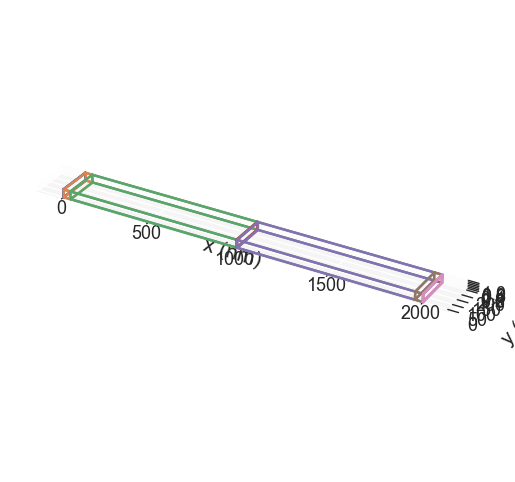

In [319]:
system_region._mesh = df.Mesh(region=system_region.main.region, 
                              cell=system_prop.cell,
                              subregions=system_subregions.regions)

system_region._mesh.mpl.subregions(figsize=(8, 6), multiplier=1e-9,box_aspect=(50, 5, 1), show_region=True)

### Energy equations

In [320]:
def h0_func(pos):
    if pos in system_subregions.driven.region:
        return h0
    else:
        return (0, 0, 0)
    #x, y, z = pos
    
    #if system_subregions.driven.p1[0] <= x < system_subregions.driven.p2[0]:
    #    return h0
    #else:
    #    return (0,0,0)

In [321]:
# system_subregions.driven.mesh = df.Mesh(region=system_region.main.region, cell=system_prop.cell)

In [322]:
h0_field = df.Field(mesh=system_region._mesh, nvdim=3, value=h0_func)
#region_values = {"region1": (1, 1, 1), "region2": (2, 2, 2)}
#h0_field.update_field_values(region_values)

In [323]:
system.energy = mm.Zeeman(H=bias_field, name='static') + mm.Exchange(A=exchange_stiffness) + mm.DMI(D=D_ij, crystalclass='Cnv_z') + mm.Demag()

In [324]:
system.energy

Zeeman(H=(0.0, 318309.8861837907, 0.0)) + Exchange(A=1.3e-11) + DMI(D=0.003, crystalclass='Cnv_z') + Demag()

### Dynamics

In [325]:
def alpha_abc_func(pos):
    # current positions
    x, y, z = pos  # spatial coordinates
    xn, yn, zn = (coord * 1e9 for coord in pos)  # cell coordinates
    
    # min and max cell coordinates of system
    xmin, ymin, zmin = (p1_val * 1e9 for p1_val in system_prop.p1)
    xmax, ymax, zmax = (p2_val * 1e9 for p2_val in system_prop.p2)
    
    # A.B.C. widths
    widths = {'x': 20, 'y':100, 'z': 1}

    # left (a) and right (b) bounds of the A.B.C. region
    xa, ya, za = xmin + widths['x'], ymin + widths['y'], zmin + widths['z']
    xb, yb, zb = xmax - widths['x'], ymax - widths['y'], zmax - widths['z']
    
    # Scales damping between [alpha, 1.0]
    if xn <= xa:
        return np.exp( ((xmin - xn) * np.log(alpha)) / (xmin - xa) )
    elif xn >= xb:
        return np.exp( ((xmax - xn) * np.log(alpha)) / (xmax - xb) )
    else:
        return alpha

In [326]:
alpha_field = df.Field(mesh=system_region._mesh, nvdim=1, value=alpha_abc_func)

In [327]:
# If value is provided here then one MUST use gamma_G (not gamma_LL) when defining subsequent evolvers
system.dynamics = mm.Precession(gamma0=gamma0*mm.consts.mu0) + mm.Damping(alpha=alpha_field)

In [328]:
system.dynamics

Precession(gamma0=221168.12281272144) + Damping(alpha=Field(Mesh(Region(pmin=[0.0, 0.0, 0.0], pmax=[2e-06, 2e-07, 1e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), n=[1000, 100, 1], subregions: (Region`fixedLhs`(pmin=[0.0, 0.0, 0.0], pmax=[2e-09, 2e-07, 1e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`dampingLhs`(pmin=[2e-09, 0.0, 0.0], pmax=[4.2e-08, 2e-07, 1e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`freeLhs`(pmin=[4.2e-08, 0.0, 0.0], pmax=[9.98e-07, 2e-07, 1e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`driven`(pmin=[9.98e-07, 0.0, 0.0], pmax=[1.002e-06, 2e-07, 1e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`freeRhs`(pmin=[1.002e-06, 0.0, 0.0], pmax=[1.958e-06, 2e-07, 1e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`dampingRhs`(pmin=[1.958e-06, 0.0, 0.0], pmax=[1.998e-06, 2e-07, 1e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`fixedRhs`(pmin=[1.998e-06, 0.0, 0.0], pmax=[2e-06, 2e-07, 1e-09], dims=['x',

In [329]:
def m_init_func(pos):
    if pos in system_subregions.fixedLhs.region or pos in system_subregions.fixedRhs.region:
        return (0.1, 0.9, 0.0)
    else:
        return (0.1, 0.9, 0.0)

In [330]:
#system.m = df.Field(mesh=system_region._mesh, nvdim=3, value=mag_vals, norm=Ms)
system.m = df.Field(mesh=system_region._mesh, nvdim=3, bc='y', value=m_init_func, norm=sat_mag)

### Relaxation

In [331]:
#oc.MinDriver._allowed_attributes

In [332]:
min_evolver = oc.CGEvolver(method='Polak-Ribiere',
                           fixed_spins=['fixedLhs', 'fixedRhs'],)

In [333]:
minD = oc.MinDriver(evolver=min_evolver,
                    stopping_mxHxm=0.1)
minD.drive(system, fixed_subregions=['fixedLhs', 'fixedRhs'], verbose=2)

Running OOMMF (TclOOMMFRunner)[2024/06/17 15:27]... 

Python(91264) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


(1.7 s)


In [334]:
fig1 = plt.figure(figsize=(12, 8))

fig1_gs = fig1.add_gridspec(2, 2,  width_ratios=(1, 4), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

<Figure size 1200x800 with 0 Axes>

In [335]:
import matplotlib.transforms as mpl_t
import matplotlib.quiver as mpl_q
import matplotlib.image as mpl_i
import matplotlib.colorbar as mpl_cbar
import matplotlib.ticker as mpl_ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [336]:
def mpl_wrapper(field, ax, multiplier, scalar_resample=None, vector_resample=None, scalar_comp=None, scalar_kw=None, vector_kw=None, mpl_kw=None):
    """
    Wrapper function for plotting with Ubermag's MplField class, allowing different resampling for scalar and vector fields.
    
    Parameters:
        field (df.Field): The field object to plot.
        ax (matplotlib.axes.Axes): The axes to plot on.
        multiplier (float): The multiplier for units.
        scalar_resample_shape (tuple): The shape to resample the scalar field to (default is None).
        vector_resample_shape (tuple): The shape to resample the vector field to (default is None).
        scalar_comp (str): The component to use for the scalar field (default is None).
        scalar_kw (dict): Keyword arguments for scalar plotting.
        vector_kw (dict): Keyword arguments for vector plotting.
    """
        
    if isinstance(mpl_kw, dict) and mpl_kw is not None and scalar_kw is None and vector_kw is None:
        ax.set(**mpl_kw)
        return
    else:
        exit(1)
        
    scalar_field = field
    vector_field = field
    
    # Resample scalar field if needed
    if scalar_resample:
        scalar_field = scalar_field.resample(scalar_resample)
    
    # Resample vector field if needed
    if vector_resample:
        vector_field = vector_field.resample(vector_resample)
    
    # Select scalar component if specified
    if scalar_comp:
        scalar_field = getattr(scalar_field, scalar_comp)
    
    # Set default keyword arguments if not provided
    if scalar_kw is None:
        scalar_kw = {}
    if vector_kw is None:
        vector_kw = {}

    # Call the MplField class
    scalar_field.mpl.scalar(ax=ax, multiplier=multiplier, **scalar_kw)
    vector_field.mpl.vector(ax=ax, multiplier=multiplier, **vector_kw)
    
    # Set matplotlib params
    if mpl_kw is None:
        mpl_kw = {}
    ax.set(aspect='auto')
    ax.set(**mpl_kw)

In [337]:
def rotate_in_place(ax, fig, rotate=True, ax_kw=None, xaxis_kw=None, yaxis_kw=None):
    
    if rotate:
        # Rotate and update image
        for img in ax.get_images():
            image_array = img.get_array()
            rotated_image_array = np.rot90(image_array, k=-1)
            new_extent = [img.get_extent()[2], img.get_extent()[3], img.get_extent()[0], img.get_extent()[1]]
            img.set(data=rotated_image_array, extent=new_extent)
    
        # Rotate and update quiver
        for quiv in ax.findobj(mpl_q.Quiver):
            x, y = quiv.X, quiv.Y
            u, v = quiv.U, quiv.V
            quiv.set(alpha=1, color='white', zorder=1.99, offsets=[[yi, xi] for xi, yi in quiv.get_offsets()])
            quiv.set_UVC(-v, u)

        # Swap axis labels and rescale to defaults
        ax.set(xlabel=ax.get_ylabel(),
               ylabel=ax.get_xlabel(),
               aspect='auto',
               anchor='W')
    
    if ax_kw is None:
        ax_kw = {}
    ax.set(**ax_kw)
    
    if xaxis_kw is None:
        xaxis_kw = {}    
    ax.xaxis.set(**xaxis_kw)

    if yaxis_kw is None:
        yaxis_kw = {}
    ax.yaxis.set(**yaxis_kw)

In [338]:
def alter_colorbar(ax, alter=True, cbar_kw=None, cbar_xaxis_kw=None, cbar_yaxis_kw=None):
    
    fig = ax.figure
    ax_pos = ax.get_position()
    
    # Loop through each AxesImage in the subplot axis
    cbar_props = {}
    for image in ax.get_images():
        if hasattr(image, 'colorbar') and image.colorbar is not None:
            # Store the association
            cbar_props = {'parent_ax': ax,
                          'cbar_ax': image.colorbar.ax,
                          'props': image.colorbar.ax.properties(),
                          'quadmesh': image.colorbar.ax.collections[1]} 
            
            # Remove old colorbar
            fig.delaxes(cbar_props['cbar_ax'])
    
    if cbar_kw is None:
        cbar_kw = {}
    
    ax_divider = make_axes_locatable(ax)
    cax = ax_divider.append_axes(cbar_kw['location'], 
                                 size=0.2, pad=0.25)
    
    # Define the new colorbar axis independently
    #if 'location' in cbar_kw and cbar_kw['location'] == 'top':
    #    cax = fig.add_axes([ax_pos.x0, ax_pos.y1 + 0.02, ax_pos.width, 0.02])
    #    orientation = 'horizontal'
    #elif 'location' in cbar_kw and cbar_kw['location'] == 'bottom':
    #    cax = fig.add_axes([ax_pos.x0, ax_pos.y0 - 0.04, ax_pos.width, 0.02])
    #    orientation = 'horizontal'
    #elif 'location' in cbar_kw and cbar_kw['location'] == 'left':
    #    cax = fig.add_axes([ax_pos.x0 - 0.04, ax_pos.y0, 0.02, ax_pos.height])
    #    orientation = 'vertical'
    #else:  # Default to 'right'
    #    cax = fig.add_axes([ax_pos.x1 + 0.02, ax_pos.y0, 0.02, ax_pos.height])
    #    orientation = 'vertical'
    
    new_cbar = fig.colorbar(cbar_props['quadmesh'],
                            cax=cax,
                            label=cbar_props['props']['ylabel'],
                            orientation='vertical')
    #new_cbar.ax.set()
    if cbar_xaxis_kw is None:
        cbar_xaxis_kw = {}
    new_cbar.ax.xaxis.set(**cbar_xaxis_kw)
    
    if cbar_yaxis_kw is None:
        cbar_yaxis_kw = {}
    new_cbar.ax.yaxis.set(**cbar_yaxis_kw)

    #new_cbar.ax.yaxis.get_major_formatter().set_useOffset(True)
    #new_cbar.ax.yaxis.get_major_formatter().set_scientific(True)
    #new_cbar.ax.yaxis.get_offset_text().set_visible(False)

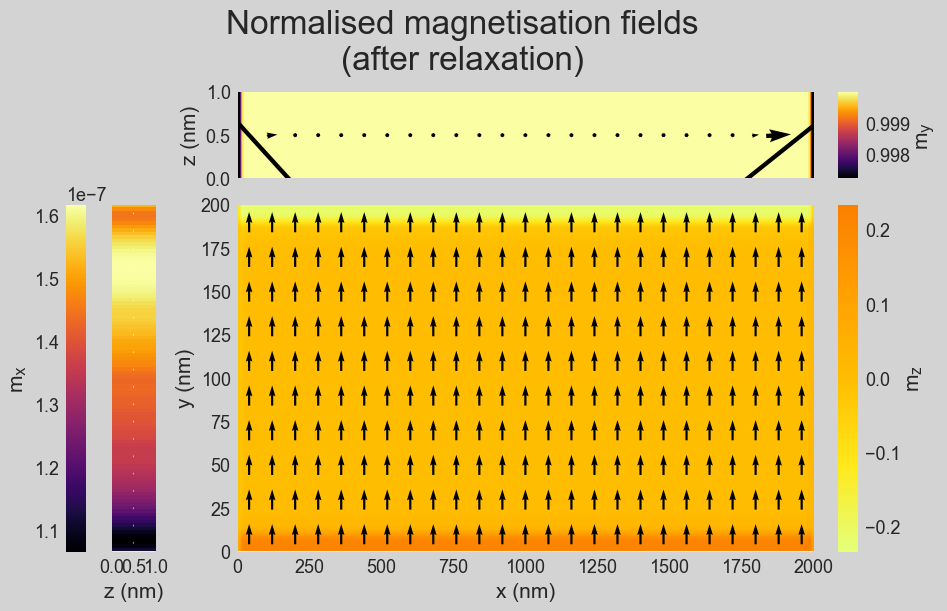

In [339]:
fig1, fig1_axs = plt.subplot_mosaic(mosaic=[['blank', 'side'], 
                                            ['end','top']],
                                    figsize=(8, 6), 
                                    gridspec_kw={'width_ratios': (1, 7),
                                                 'height_ratios': (1, 4),
                                                 'wspace': 0.0,
                                                 'hspace': 0.0},
                                    layout='constrained',
                                    facecolor='lightgrey'
                              )

fig1.suptitle('Normalised magnetisation fields\n(after relaxation)', fontsize=24)

mpl_wrapper(system.m.orientation.sel('x'), 
            ax=fig1_axs['end'], 
            multiplier=1e-9, 
            scalar_resample=(100, 1), 
            vector_resample=(20, 1),
            scalar_comp='x', 
            scalar_kw={'cmap': 'inferno', 'colorbar_label': 'm$_\\text{x}$'}, 
            vector_kw={'vdims': ['y', 'z'], 'color': 'black', 'use_color': False,
                       'colorbar': False, 'color_field': system.m.orientation.x.sel("x")},
            mpl_kw={'title': ''})

rotate_in_place(fig1_axs['end'], 
                fig1,
                ax_kw={'ylabel': '', 'yticklabels': ''},
                xaxis_kw={'ticks_position': 'bottom', 'label_position': 'bottom'},
                yaxis_kw={'ticks_position': 'right', 'label_position': 'right'})
alter_colorbar(fig1_axs['end'],
               cbar_kw={'location':'left'},
               cbar_xaxis_kw={},
               cbar_yaxis_kw={'ticks_position': 'left', 'label_position': 'left'})


for ax in [fig1_axs['blank']]:
    ax.clear()
    ax.set_visible(False)

mpl_wrapper(system.m.orientation.sel('y'), 
            ax=fig1_axs['side'], 
            multiplier=1e-9, 
            scalar_resample=(200, 1), 
            vector_resample=(25, 1),
            scalar_comp='y', 
            scalar_kw={'cmap': 'inferno','colorbar_label': 'm$_\\text{y}$'}, 
            vector_kw={'vdims': ['x', 'z'], 'color': 'black', 'use_color': False,
                       'colorbar': False, 'color_field': system.m.orientation.z.sel("y")},
            mpl_kw={})

rotate_in_place(fig1_axs['side'], 
                fig1,
                rotate=False,
                ax_kw={'title': '', 'xlabel': '', 'xticklabels': ''},
                xaxis_kw={'ticks_position': 'bottom', 'label_position': 'bottom'},
                yaxis_kw={'ticks_position': 'left', 'label_position': 'left'})
alter_colorbar(fig1_axs['side'],
               cbar_kw={'location': 'right'})

mpl_wrapper(system.m.orientation.sel('z'), 
            ax=fig1_axs['top'], 
            multiplier=1e-9, 
            scalar_resample=(200, 20), 
            vector_resample=(25, 10),
            scalar_comp='z', 
            scalar_kw={'cmap': 'Wistia', 'colorbar_label': 'm$_\\text{z}$'}, 
            vector_kw={'vdims': ['x', 'y'], 'color': 'black', 'use_color': False},
            mpl_kw={'title': '',
                    'aspect': 'auto'})

rotate_in_place(fig1_axs['top'], 
                fig1,
                rotate=False,
                ax_kw={'title': ''},
                xaxis_kw={'ticks_position': 'bottom', 'label_position': 'bottom'},
                yaxis_kw={'ticks_position': 'left', 'label_position': 'left'})

alter_colorbar(fig1_axs['top'],
               cbar_kw={'location': 'right'})

In [340]:
#m = system.m.orientation

### Time-dependent field

In [341]:
system.energy += mm.Zeeman(H=h0_field, name='pump', func='sinc',f=f, t0=50*h)

In [342]:
system.energy

Zeeman(H=(0.0, 318309.8861837907, 0.0)) + Exchange(A=1.3e-11) + DMI(D=0.003, crystalclass='Cnv_z') + Demag() + Zeeman(H=Field(Mesh(Region(pmin=[0.0, 0.0, 0.0], pmax=[2e-06, 2e-07, 1e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), n=[1000, 100, 1], subregions: (Region`fixedLhs`(pmin=[0.0, 0.0, 0.0], pmax=[2e-09, 2e-07, 1e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`dampingLhs`(pmin=[2e-09, 0.0, 0.0], pmax=[4.2e-08, 2e-07, 1e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`freeLhs`(pmin=[4.2e-08, 0.0, 0.0], pmax=[9.98e-07, 2e-07, 1e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`driven`(pmin=[9.98e-07, 0.0, 0.0], pmax=[1.002e-06, 2e-07, 1e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`freeRhs`(pmin=[1.002e-06, 0.0, 0.0], pmax=[1.958e-06, 2e-07, 1e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`dampingRhs`(pmin=[1.958e-06, 0.0, 0.0], pmax=[1.998e-06, 2e-07, 1e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`fixedRhs`(

In [343]:
sim_evolver = oc.RungeKuttaEvolver(method='rkf54',
                                   alpha=alpha,
                                   gamma_G=gamma0*mm.consts.mu0,
                                   fixed_spins=['fixedLhs', 'fixedRhs'],
                                   do_precess=1,
                                   allow_signed_gamma=0)

In [344]:
td = oc.TimeDriver(evolver=sim_evolver)
td.drive(system, t=tmax, n=num_steps, fixed_subregions=['fixedLhs', 'fixedRhs'], n_threads=8, verbose=2)

Running OOMMF (TclOOMMFRunner):   0%|          | 0/4000 files written [00:00]

Python(91286) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Running OOMMF (TclOOMMFRunner)[2024/06/17 15:27] took 456.1 s


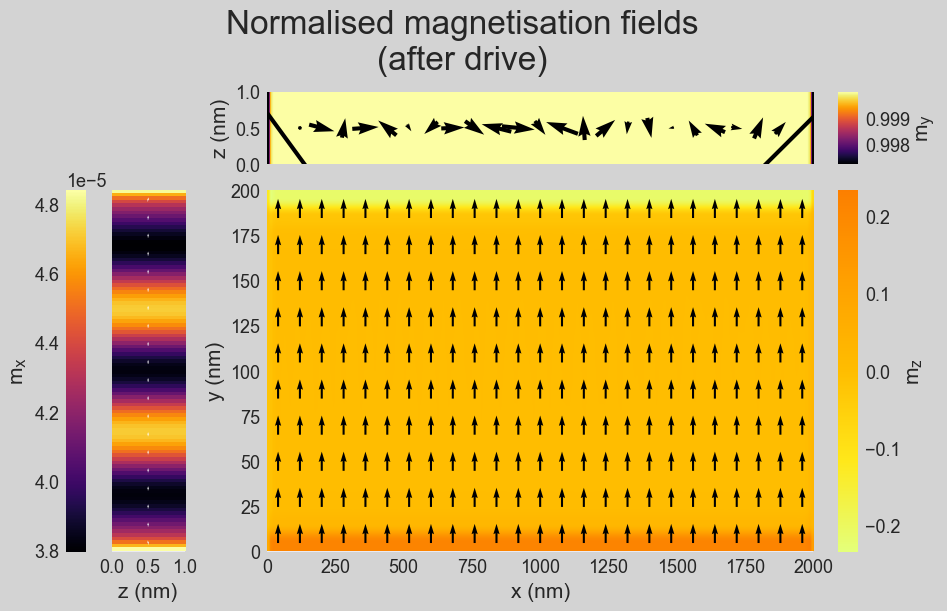

In [345]:
fi2, fig2_axs = plt.subplot_mosaic(mosaic=[['blank', 'side'], 
                                            ['end','top']],
                                    figsize=(8, 6), 
                                    gridspec_kw={'width_ratios': (1, 5),
                                                 'height_ratios': (1, 5),
                                                 'wspace': 0.0,
                                                 'hspace': 0.0},
                                    layout='constrained',
                                    facecolor='lightgrey'
                              )

fi2.suptitle('Normalised magnetisation fields\n(after drive)', fontsize=24)

mpl_wrapper(system.m.orientation.sel('x'), 
            ax=fig2_axs['end'], 
            multiplier=1e-9, 
            scalar_resample=(100, 1), 
            vector_resample=(20, 1),
            scalar_comp='x', 
            scalar_kw={'cmap': 'inferno', 'colorbar_label': 'm$_\\text{x}$'}, 
            vector_kw={'vdims': ['y', 'z'], 'color': 'black', 'use_color': False,
                       'colorbar': False, 'color_field': system.m.orientation.x.sel("x")},
            mpl_kw={'title': ''})

rotate_in_place(fig2_axs['end'], 
                fi2,
                ax_kw={'ylabel': '', 'yticklabels': ''},
                xaxis_kw={'ticks_position': 'bottom', 'label_position': 'bottom'},
                yaxis_kw={'ticks_position': 'right', 'label_position': 'right'})
alter_colorbar(fig2_axs['end'],
               cbar_kw={'location':'left'},
               cbar_xaxis_kw={},
               cbar_yaxis_kw={'ticks_position': 'left', 'label_position': 'left'})


for ax in [fig2_axs['blank']]:
    ax.clear()
    ax.set_visible(False)

mpl_wrapper(system.m.orientation.sel('y'), 
            ax=fig2_axs['side'], 
            multiplier=1e-9, 
            scalar_resample=(200, 1), 
            vector_resample=(25, 1),
            scalar_comp='y', 
            scalar_kw={'cmap': 'inferno','colorbar_label': 'm$_\\text{y}$'}, 
            vector_kw={'vdims': ['x', 'z'], 'color': 'black', 'use_color': False,
                       'colorbar': False, 'color_field': system.m.orientation.z.sel("y")},
            mpl_kw={})

rotate_in_place(fig2_axs['side'], 
                fi2,
                rotate=False,
                ax_kw={'title': '', 'xlabel': '', 'xticklabels': ''},
                xaxis_kw={'ticks_position': 'bottom', 'label_position': 'bottom'},
                yaxis_kw={'ticks_position': 'left', 'label_position': 'left'})
alter_colorbar(fig2_axs['side'],
               cbar_kw={'location': 'right'})

mpl_wrapper(system.m.orientation.sel('z'), 
            ax=fig2_axs['top'], 
            multiplier=1e-9, 
            scalar_resample=(200, 20), 
            vector_resample=(25, 10),
            scalar_comp='z', 
            scalar_kw={'cmap': 'Wistia', 'colorbar_label': 'm$_\\text{z}$'}, 
            vector_kw={'vdims': ['x', 'y'], 'color': 'black', 'use_color': False},
            mpl_kw={'title': '',
                    'aspect': 'auto'})

rotate_in_place(fig2_axs['top'], 
                fi2,
                rotate=False,
                ax_kw={'title': ''},
                xaxis_kw={'ticks_position': 'bottom', 'label_position': 'bottom'},
                yaxis_kw={'ticks_position': 'left', 'label_position': 'left'})

alter_colorbar(fig2_axs['top'],
               cbar_kw={'location': 'right'})

In [346]:
m_all_data = md.Drive(name=system.name, number=system.drive_number - 1)
data_m0 = m_all_data.m0.to_xarray().values

In [347]:
m_pos = [int(system_prop.cell[1]//2), int(system_prop.cell[2]//2)]

In [348]:
data_mx0 = data_m0[:, m_pos[0], m_pos[1], 0] / sat_mag
data_my0 = data_m0[:, m_pos[0], m_pos[1], 1] / sat_mag
data_mz0 = data_m0[:, m_pos[0], m_pos[1], 2] / sat_mag

In [349]:
data_mx0.shape

(1000,)

In [350]:
data_mx = np.zeros((m_all_data.n, int(system_prop.numcells[0])))
data_my = np.zeros((m_all_data.n, int(system_prop.numcells[0])))
data_mz = np.zeros((m_all_data.n, int(system_prop.numcells[0])))

In [351]:
data_mx.shape

(4000, 1000)

In [352]:
m_data = m_all_data.to_xarray()

In [353]:
for i, _ in enumerate(m_data):
    data_mx[i] = (m_data[i, :, m_pos[0], m_pos[1], 0].values / sat_mag) - data_mx0
    #data_my[i] = (m_data[i, :, m_pos[0], m_pos[1], 1].values / sat_mag) - data_my0
    #data_mz[i] = (m_data[i, :, m_pos[0], m_pos[1], 2].values / sat_mag) - data_mz0

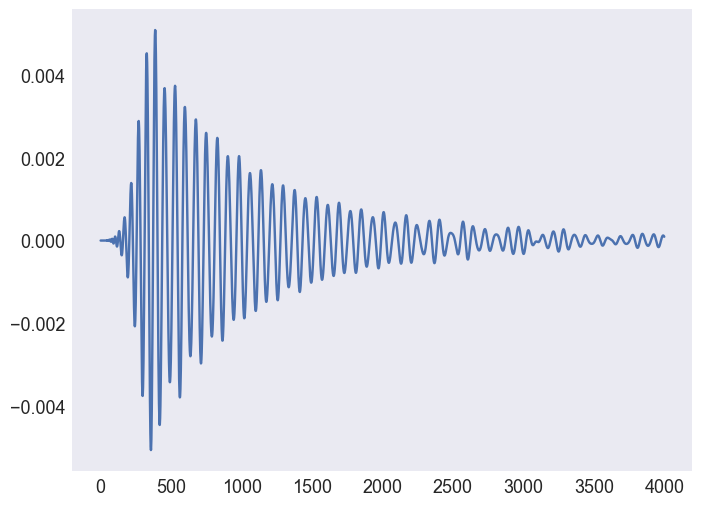

In [360]:
plt.plot(np.arange(0, num_steps, 1), data_mx[:, 400])

In [355]:
def Omega_Moon(H0, Ms, A, D, k, d, gamma, p=1):
    J = 2 * A / (mm.consts.mu0 * Ms)
    DM = 2 * D / (mm.consts.mu0 * Ms)
    
    om = np.sqrt((H0 + 0.25 * Ms + J * (k ** 2)) * (H0 + 3 * Ms * 0.25 + J * (k **2))
                 - (1 + 2 * np.exp(2 * abs(k) * d)) * np.exp(-4 * abs(k) * d) * (Ms ** 2) / 16 
                 ) 
    om += p * DM * k
    
    # the mu0 factor shown in the paper is not necessary if we use gamma
    # in Hz / (A / m)
    om = (gamma) * om
    
    return om

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


[Text(0.5, 0, 'Wavevector, $k$ (nm$^{-1}$)'),
 Text(0, 0.5, 'Frequency, $f$ (GHz)')]

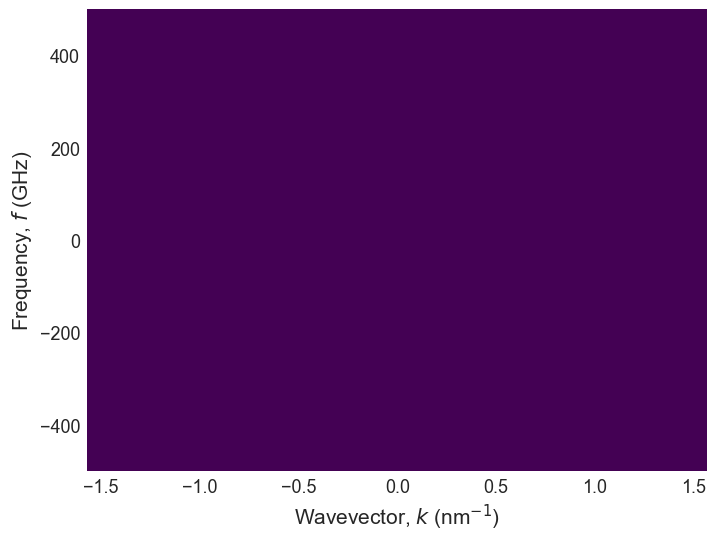

In [365]:
kmax = 0.4 * 1e9
ks = np.linspace(1e-10, kmax, int(system_prop.numcells[0]//2))
ks_n = np.linspace(-kmax, 1e-10, int(system_prop.numcells[0]//2))
oms = Omega_Moon(bias_field[1], sat_mag, exchange_stiffness, D_ij, ks, 1e-9, gamma0 * mm.consts.mu0 / (2 * np.pi * 1e9), p=1)
oms_n = Omega_Moon(bias_field[1], sat_mag, exchange_stiffness, D_ij, ks_n, 1e-9, gamma0 * mm.consts.mu0 / (2 * np.pi * 1e9), p=1) 

fft_data = np.fft.fft2(data_my)
fft_data = abs(np.fft.fftshift(fft_data))
times = m_data['t'].values
x = m_data['x'].values

freqs = np.fft.fftfreq(n=len(times), d=(times[1] - times[0])) * 1e-9
freqs = np.fft.fftshift(freqs)
k = np.fft.fftfreq(n=len(x), d=(x[1] - x[0])) / 1e9
k = np.fft.fftshift(k) * 2 * np.pi
# fft_data = np.log10(fft_data ** 2)
f, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(fft_data, extent=[k[0], k[-1], freqs[0], freqs[-1]], 
          aspect='auto', interpolation='none',
           cmap='bone_r')

ax.plot(ks * 1e-9, oms, lw=2, ls='--', color='C3', label='Theory')
ax.plot(ks_n * 1e-9, oms_n, lw=2, ls='--', color='C3')


ax.set(xlabel=r'Wavevector, $k$ (nm$^{-1}$)', ylabel=r'Frequency, $f$ (GHz)')


handles, labels = ax.get_legend_handles_labels()
blacks = matplotlib.patches.Patch(color='k', label='OOMMf')
l = ax.legend(handles=[handles[0], blacks])

In [ ]:
m_vals = np.empty((my_data.n, 3))

for i in range(0, my_data.n):
    m_vals[i] = my_data[i].to_xarray()[system_prop.numcells[0], 0, 0]

In [ ]:
fig3, fig3_axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), sharex=True)
fig3.suptitle(f'Magnetisation fields at different positions', fontsize=24)

fig3_cell1 = 100
fig3_axs[0].plot(my_data.table.data['t'].to_numpy(),
         my_data.to_xarray()[:, fig3_cell1, 0, 0,0])
fig3_axs[0].set(title=f'Cell: {fig3_cell1 * system_prop.cell[0]: 2.2e}', ylabel='m$_\\text{x}$ (A m$^{-1}$)')

fig3_cell2 = 500
fig3_axs[1].plot(my_data.table.data['t'].to_numpy(),
         my_data.to_xarray()[:, fig3_cell2, 0, 0,0])
fig3_axs[1].set(title=f'Cell: {fig3_cell2 * system_prop.cell[0]: 2.2e}', 
                xlabel='Time, t (ns)', ylabel='m$_\\text{x}$ (A m$^{-1}$)')
plt.show()

In [ ]:
def plt_mag(t_val):
    fig4, fig4_axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
    fig4.suptitle('Magnetisation fields after drive', fontsize=24)
    
    my_data[t_val].orientation.sel('y').resample((256, 2)).x.mpl.scalar(ax=fig4_axs[0], cmap='inferno', colorbar_label='m$_\\text{x}$ (normalised)')
    my_data[t_val].orientation.sel('y').resample((32, 1)).mpl.vector(ax=fig4_axs[0],
                                                   #color_field=system.m.orientation.y.sel("y"),
                                                   color='black', alpha=0,
                                                   use_color=False,
                                                   colorbar=False)
    fig4_axs[0].set(title='Top elevation (xz plane)', aspect=180)
    
    my_data[t_val].orientation.sel('z').resample((256, 2)).z.mpl.scalar(ax=fig4_axs[1], cmap='Wistia', colorbar_label='m$_\\text{z}$ (normalised)')
    my_data[t_val].orientation.sel('z').resample((32, 1)).mpl.vector(ax=fig4_axs[1],
                                                   color='black',
                                                   use_color=False)
    
    fig4_axs[1].set(title='End elevation (xy plane)', aspect=180)
    
    
    fig4.tight_layout()

In [ ]:
my_data.table.data['t'].to_numpy()

In [ ]:
plt.plot()

In [ ]:
#system.m

In [ ]:
system.table.data.plot('t', 'mx', xlabel='time, t (ns)', ylabel='avg. m$_\\text{x}$ (A m$^{-1}$)')

In [ ]:
position = (1024e-9, 0, 0)

In [ ]:
system.m.orientation((position[0], position[1], position[2]))

In [ ]:
import os

In [ ]:
# Define the directory containing your .omf files
omf_dir = '/Users/cameronmceleney/PycharmProjects/Ubermag/include/breaking_test/drive-14'

# List all .omf files in the directory
omf_files = sorted([f for f in os.listdir(omf_dir) if f.endswith('.omf') and f != 'm0.omf'])

In [ ]:
times = system.table.data['t']

In [ ]:
my_data = md.Drive(name='dmi_sp', number=3)

In [ ]:
my_data.table.data

In [ ]:
# Initialize lists to store magnetization components
times = []
mx_values = []
my_values = []
mz_values = []

# Read each .omf file and extract the magnetization at the specified position
for omf_file in omf_files:
    # Read the field from the .omf file
    field = df.Field.from_file(os.path.join(omf_dir, omf_file))
    exit(0)
    
    # Extract the magnetization components at the specified position
    m_at_pos = field(position)
    mx_values.append(m_at_pos[0])
    my_values.append(m_at_pos[1])
    mz_values.append(m_at_pos[2])
    
    # Extract the time from the filename (assuming filenames have time information)
    # Example: "filename_t=0.omf" -> time = 0
    time = float(omf_file.split('t=')[1].split('.omf')[0])
    times.append(time)

In [ ]:
plt.plot(times, mx_values)

In [ ]:
# Plot the magnetization components over time
plt.figure(figsize=(8, 6))
plt.plot(times, mx_values, label='m$_\\text{x}$ (normalized)')
plt.plot(times, my_values, label='m$_\\text{y}$ (normalized)')
#plt.plot(times, mz_values, label='m$_\\text{z}$ (normalized)')
plt.xlabel('Time (s)')
plt.ylabel('Magnetization (normalized)')
plt.title('Magnetization components at position {} over time'.format(position))
plt.legend()
plt.grid()
plt.show()

In [ ]:
fig2, (fig2_ax1, fig2_ax2, fig2_ax3) = plt.subplots(nrows=3, ncols=1, figsize=(20, 5))
fig2.suptitle('Magnetisation fields after relaxation (y-plane)', fontsize=24)

# plot vectors on grid of 20 x 5 over the numerical resulotion
system.m.x.sel("y").mpl(ax=fig2_ax1, scalar_kw={"colorbar_label": "m$_\\text{x}$ (A m$^{-1}$)"})
fig2_ax1.set(aspect=200)

system.m.y.sel('y').mpl(ax=fig2_ax2, scalar_kw={"colorbar_label": "m$_\\text{y}$ (A m$^{-1}$)"})
fig2_ax2.set(aspect=200)

system.m.z.sel('y').mpl(ax=fig2_ax3, scalar_kw={"colorbar_label": "m$_\\text{z}$ (A m$^{-1}$)"})
fig2_ax3.set(aspect=200)

In [ ]:
data = md.Data(system.name)

In [ ]:
data.info

In [ ]:
# Use only the last time drive
time_drive = data[1]
time_drive.info
print(time_drive.calculator_script)

In [ ]:
#list(time_drive)
#time_drive.to_xarray()

In [ ]:
fig3, fig3_axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
time_drive[700].sel('y').mpl(ax=fig3_axs, vector_kw={'color':'white', 'alpha':0})
fig3_axs.set(aspect=60)

In [ ]:
data_oi = []

In [ ]:

time_drive.hv(
    kdims=["x", "y"],
    scalar_kw={"clim": (-Ms, Ms), "cmap": "coolwarm"},
)